<a href="https://colab.research.google.com/github/vohoaidanh/AIGCDetectBenchmark/blob/main/colab/pytorch_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AIGCDetectBenchmark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install ftfy -q
!pip install natsort -q
!pip install tensorboardX -q
!pip install blobfile -q
!pip install mpi4py -q
!pip install grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/vohoaidanh/AIGCDetectBenchmark.git

Cloning into 'AIGCDetectBenchmark'...
remote: Enumerating objects: 757, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 757 (delta 22), reused 8 (delta 1), pack-reused 708
Receiving objects: 100% (757/757), 7.23 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (360/360), done.


In [ ]:
%cd /content/AIGCDetectBenchmark

/content/AIGCDetectBenchmark


In [ ]:
import torch
import numpy as np
from networks.resnet import resnet50
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix

#from options import TestOptions
#from data import create_dataloader, create_dataloader_new
#from data.process import get_processing_model
#from data.datasets import loadpathslist,custom_augment,process_img
from PIL import Image

if __name__ == '__main__':
    #opt = TestOptions().parse(print_options=False)
    model_path = '/content/drive/MyDrive/WEIGHTS/CNNSpot240420/RealFakeDB512/model_epoch_latest.pth'
    model = resnet50(num_classes=1)
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict['model'])
    #model.cuda()
    model.eval()


In [ ]:
!unzip -q /content/drive/MyDrive/DATASETS/Common/RealFakeDB_tiny_test.zip -d /content

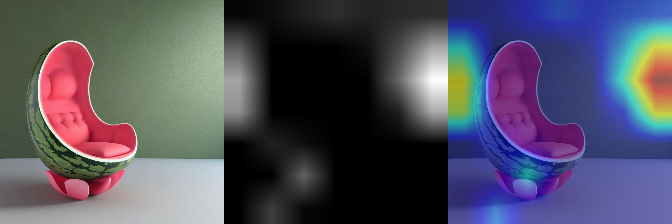

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import os
#model = models.resnet50(pretrained=True)
model.eval()
imgs = os.listdir('/content/real_gen_dataset/test/1_fake')
idx = np.random.randint(len(imgs))
image_url = os.path.join('/content/real_gen_dataset/test/1_fake', imgs[idx])
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
#targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4[-1]]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor)#, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)